In [1]:
import matplotlib.pyplot as plt
import torch as tc
from torchdiffeq import odeint
from torch import nn
from data import get_cases

In [2]:
cases, cum_cases, N = get_cases()

I0 = 1
R0 = 0
S0 = N - I0 - R0
y0 = tc.tensor([S0, I0, R0, N]).float()

data = S0 - cum_cases

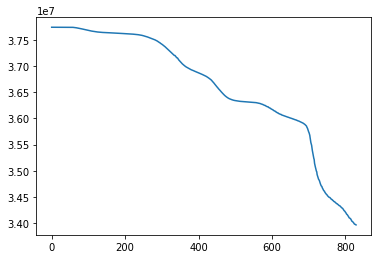

In [3]:
plt.plot(data)

In [72]:
class ODE(nn.Module):

    def __init__(self, y0, data, N):
        super(ODE, self).__init__()
        self.gamma = 0.06
        self.y0 = y0
        self.data = tc.tensor(data).float()
        self.N = N
        self.T = len(data)
        self.tspan = tc.arange(0.0, len(data)).float()
        self.n = 10
        self.a0 = nn.Parameter(tc.tensor(0.2))
        self.a = nn.Parameter(tc.zeros(self.n - 1))
        self.b = nn.Parameter(tc.zeros(self.n - 1))
        self.sigmoid = nn.Sigmoid()
        

    def betafn(self, t):
        x = tc.full((self.n - 1,), t.item()) * 2 * tc.pi / self.T - self.T / 2 #scaled input t
        nspan = tc.arange(1, self.n, dtype=float) #n values
        x = nspan * x #element-wise mult.
        return self.sigmoid((1/2) * self.a0 + (self.a * tc.cos(x) + self.b * tc.sin(x)).sum().squeeze())
        
    def forward(self, t, y):
        S, I, R, N = y

        beta = self.betafn(t)
        dS = - beta * S * I / N
        dI = beta * S * I / N - self.gamma * I
        dR = self.gamma * I
        dN = tc.tensor(0.0)

        return tc.stack([dS, dI, dR, dN])
    
    def predict(self):
        S, I, R, N = odeint(self, self.y0, self.tspan).T
        return S, I, R, N
    
    def likelihood(self):
        S, I, R, _ = self.predict()
        return (1/N) * (S.mean() - (1/len(self.tspan)) * tc.dot(S.log(), self.data))
    
    def L2(self):
        S, I, R, _ = self.predict()
        return tc.sqrt(((S - self.data)**2).mean())

In [81]:
func = ODE(y0 = y0, data = data, N = N)

optimizer = tc.optim.Adam(func.parameters(), lr=0.1)

losses = []

for i in range(1000):
    optimizer.zero_grad()
    l = func.likelihood()
    
    l.backward()
    if i%5==0 : print("Loss : {}".format(l))
    optimizer.step()
    losses.append(l.clone().detach())


Loss : -8.968239784240723
Loss : -14.197063446044922
Loss : -14.633810997009277
Loss : -14.778610229492188
Loss : -14.8059720993042
Loss : -14.911968231201172
Loss : -14.896687507629395
Loss : -14.906704902648926
Loss : -15.005507469177246
Loss : -15.049375534057617
Loss : -15.079289436340332
Loss : -15.1126708984375
Loss : -15.139019012451172
Loss : -15.166611671447754
Loss : -15.193974494934082
Loss : -15.221410751342773
Loss : -15.249737739562988
Loss : -15.279016494750977
Loss : -15.309349060058594
Loss : -15.34057903289795
Loss : -15.372556686401367
Loss : -15.405289649963379
Loss : -15.438825607299805
Loss : -15.47271728515625
Loss : -15.506241798400879
Loss : -15.538986206054688
Loss : -15.571004867553711
Loss : -15.603043556213379
Loss : -15.635830879211426
Loss : -15.669415473937988
Loss : -15.70244026184082
Loss : -15.731874465942383
Loss : -15.755073547363281
Loss : -15.773314476013184
Loss : -15.787556648254395
Loss : -15.798266410827637
Loss : -15.807306289672852
Loss : -1

Text(0, 0.5, 'Loss')

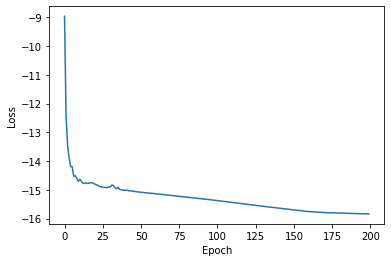

In [82]:
#Losses

plt.plot(tc.stack(losses))
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0.5, 1.0, '$\\beta (t)$')

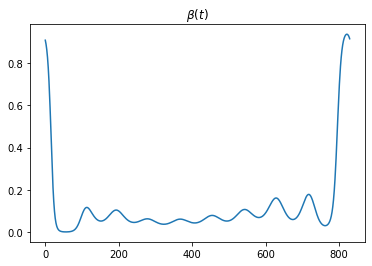

In [83]:
#Beta

plt.plot([func.betafn(tc.tensor([t])).detach().clone() for t in func.tspan])
plt.title(r"$\beta (t)$")

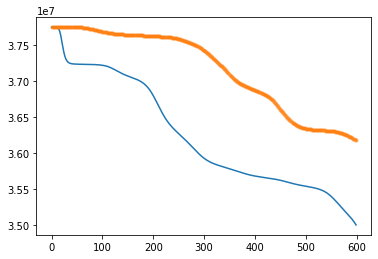

In [85]:
#Fit

S, I, R, _ = func.predict()

plt.plot(S.detach()[:600])
plt.plot(data[:600], '.', alpha=0.3)